In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import minimize
from scipy.stats import ks_2samp, mannwhitneyu, mode
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Loading the Data
## Global 1: train_combined, labels

In [ ]:
SEED = 3407
REPEATS = 4
FOLDS = 4

train_q = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_c = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_f = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
test_q = pd.read_excel("/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

train_combined = pd.merge(train_q, train_c, on="participant_id", how="left").set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on="participant_id", how="left").set_index("participant_id")

labels = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

train_combined = train_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "Label IDs don't match train IDs"

# Preprocessing
## Global 2: y_adhd, y_sex

In [ ]:
# Drop columns 
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_combined.drop(drop_cols, axis=1, inplace=True)
test_combined.drop(drop_cols, axis=1, inplace=True)

# Standardize features
scaler = StandardScaler()
train_combined = pd.DataFrame(
    scaler.fit_transform(train_combined), columns=train_combined.columns, index=train_combined.index
)
test_combined = pd.DataFrame(
    scaler.transform(test_combined), columns=test_combined.columns, index=test_combined.index
)

# Impute missing values using IterativeImputer with Lasso
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=5, random_state=SEED)
train_combined[:] = imputer.fit_transform(train_combined)
test_combined[:] = imputer.transform(test_combined)

# Retrieve targets
y_adhd = labels["ADHD_Outcome"]
y_sex = labels["Sex_F"]
# ADHD&Sex Combinations to stratify on
combinations = labels["ADHD_Outcome"].astype(str) + labels["Sex_F"].astype(str)

# Logistic regressionCV
## Model Evaluation

In [ ]:
features_sex = [
       'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu'
]

features_adhd = [
       'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu', 'sex_proba',
       'I_APQ_P_APQ_P_INV', 'I_APQ_P_APQ_P_PP', 'I_SDQ_SDQ_Hyperactivity',
       'I_MRI_Track_Age_at_Scan', 'I_SDQ_SDQ_Generating_Impact'
]

# Features to be interacted with predicted probability of Sex_F = 1
interactions = [
    "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PP", "SDQ_SDQ_Hyperactivity", 
    "MRI_Track_Age_at_Scan", "SDQ_SDQ_Generating_Impact"
]

In [ ]:
!pip install -q optuna

In [ ]:
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using Brier Score and F1 Score."""
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# store oof brier and f1
scores_sex = []
scores_adhd = []

# store oof predictions for diagnostics and threshold optimization
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))

# classification thresholds
t_sex = 0.3
t_adhd = 0.4

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
# skf for LogisticRegressionCV
skf = StratifiedKFold(n_splits=FOLDS)

params_1 = {
    "penalty":"l1", 
    "Cs": 13, 
    "cv":skf, 
    "fit_intercept":True, 
    "scoring": "f1", 
    "random_state": SEED, 
    "solver": "saga"
}

params_2 = {
    "penalty":"l2", 
    "Cs": 7, 
    "cv":skf, 
    "fit_intercept":True, 
    "scoring": "f1", 
    "random_state": SEED, 
    "solver": "saga"
}


=== Fold 1 ===
Sex_F -> Brier Score: 0.2169, F1: 0.6320
Outcome ADHD -> Brier Score: 0.1430, F1: 0.8828

=== Fold 2 ===
Sex_F -> Brier Score: 0.2331, F1: 0.6167
Outcome ADHD -> Brier Score: 0.1401, F1: 0.8916

=== Fold 3 ===
Sex_F -> Brier Score: 0.2202, F1: 0.6087
Outcome ADHD -> Brier Score: 0.1410, F1: 0.8763

=== Fold 4 ===
Sex_F -> Brier Score: 0.2294, F1: 0.6281
Outcome ADHD -> Brier Score: 0.1486, F1: 0.8769

=== Fold 5 ===
Sex_F -> Brier Score: 0.2272, F1: 0.6376
Outcome ADHD -> Brier Score: 0.1295, F1: 0.9066

=== Fold 6 ===
Sex_F -> Brier Score: 0.2244, F1: 0.6387
Outcome ADHD -> Brier Score: 0.1511, F1: 0.8774

=== Fold 7 ===
Sex_F -> Brier Score: 0.2324, F1: 0.6314
Outcome ADHD -> Brier Score: 0.1532, F1: 0.8807

=== Fold 8 ===
Sex_F -> Brier Score: 0.2226, F1: 0.6192
Outcome ADHD -> Brier Score: 0.1318, F1: 0.8938

=== Fold 9 ===
Sex_F -> Brier Score: 0.2387, F1: 0.6057
Outcome ADHD -> Brier Score: 0.1392, F1: 0.8866

=== Fold 10 ===
Sex_F -> Brier Score: 0.2247, F1: 0.64

In [ ]:
model_1 = LogisticRegressionCV(**params_1)
model_2 = LogisticRegressionCV(**params_2)

for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
# for fold, (train_idx, val_idx) in enumerate(mskf.split(train_combined, labels)):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = train_combined.iloc[train_idx], train_combined.iloc[val_idx]
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]
    # 2x weight for Sex_F == 1 and ADHD_Outcome == 1 (as mentioned in competition evaluation)
    weights_train = np.where(combinations.iloc[train_idx]=="11", 2, 1)
    weights = np.where(combinations.iloc[val_idx]=="11", 2, 1)

    # ----------------
    # Sex_F prediction
    # ----------------
    # Model 1
    model_1.fit(X_train[features_sex], y_train_sex, sample_weight=weights_train)
    sex_train = model_1.predict_proba(X_train[features_sex])[:, 1]
    sex_val = model_1.predict_proba(X_val[features_sex])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS

    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", thresh=t_sex)
    scores_sex.append((sex_brier, sex_f1))

    # ----------------
    # Outcome_ADHD prediction
    # ----------------
    # Add predicted proba from previous model
    X_train["sex_proba"] = sex_train
    X_val["sex_proba"] = sex_val

    # adding interactions between predicted sex and other features
    for interaction in interactions:
        X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
        X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]

    # Logistic Regression with L1 penalty
    model_2.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train)
    
    adhd_val = model_2.predict_proba(X_val[features_adhd])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "Outcome ADHD", thresh=t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))

print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")

## Threshold Optimization

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

ADHD Thresholds: 100%|██████████| 100/100 [00:00<00:00, 377.42it/s]


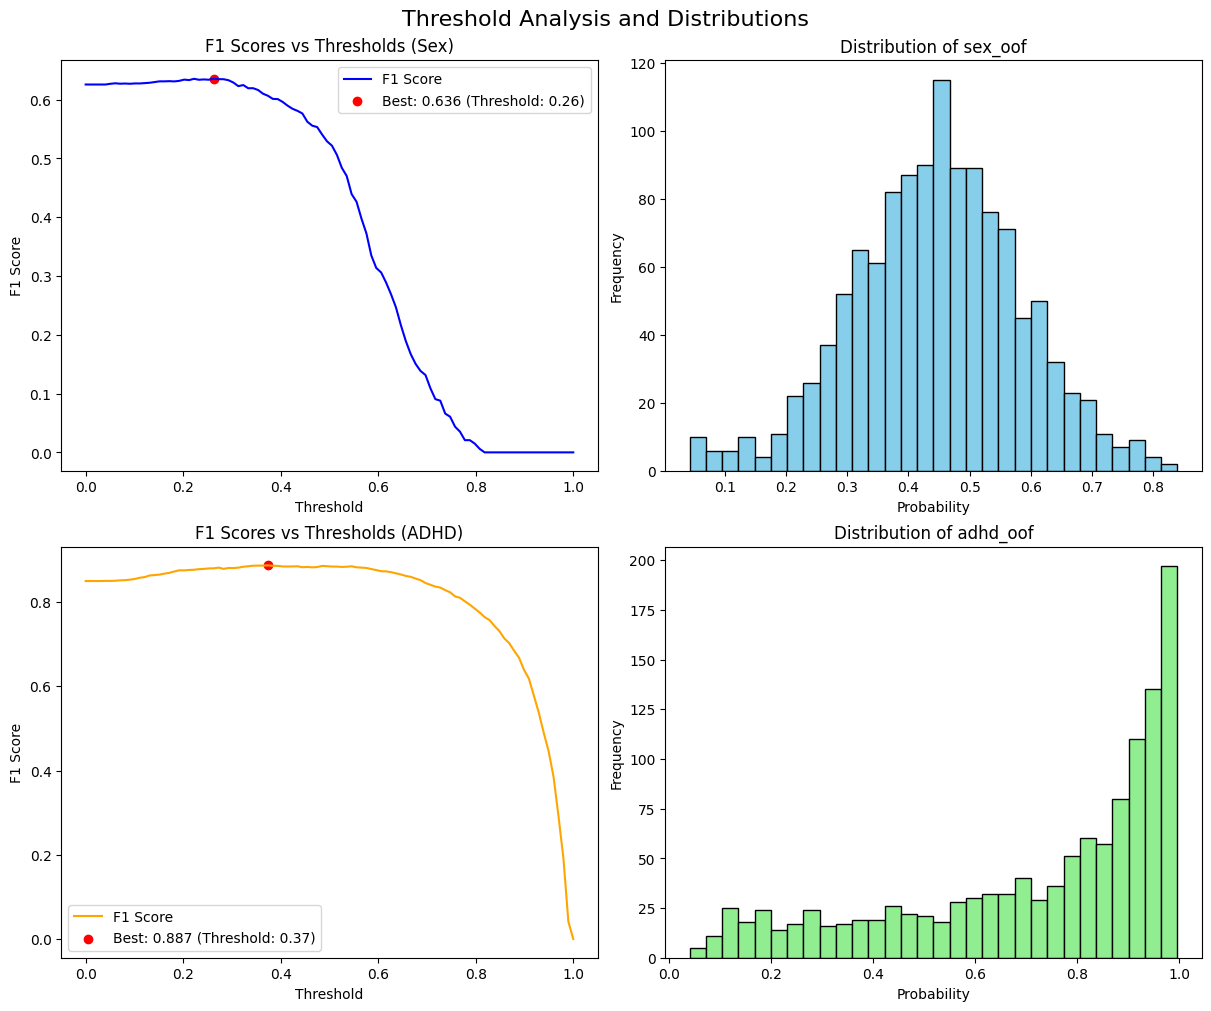

In [ ]:
weights = ((y_adhd == 1) & (y_sex == 1)) + 1
# Compute F1 scores and find the best threshold for sex_oof
thresholds = np.linspace(0, 1, 1000)
sex_scores = []
for t in tqdm(thresholds, desc="Sex Thresholds"):
    tmp_pred = np.where(sex_oof > t, 1, 0)
    tmp_score = f1_score(y_sex, tmp_pred, sample_weight=weights)
    sex_scores.append(tmp_score)
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_sex_score = max(sex_scores)

# Compute F1 scores and find the best threshold for adhd_oof
adhd_scores = []
for t in tqdm(thresholds, desc="ADHD Thresholds"):
    tmp_pred = np.where(adhd_oof > t, 1, 0)
    tmp_score = f1_score(y_adhd, tmp_pred, sample_weight=weights)
    adhd_scores.append(tmp_score)
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
best_adhd_score = max(adhd_scores)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Plot F1 scores for sex_oof
axs[0, 0].plot(thresholds, sex_scores, label='F1 Score', color='blue')
axs[0, 0].scatter(best_sex_threshold, best_sex_score, color='red', label=f'Best: {best_sex_score:.3f} (Threshold: {best_sex_threshold:.2f})')
axs[0, 0].set_title('F1 Scores vs Thresholds (Sex)')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].legend()

# Plot histogram of sex_oof
axs[0, 1].hist(sex_oof, bins=30, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of sex_oof')
axs[0, 1].set_xlabel('Probability')
axs[0, 1].set_ylabel('Frequency')

# Plot F1 scores for adhd_oof
axs[1, 0].plot(thresholds, adhd_scores, label='F1 Score', color='orange')
axs[1, 0].scatter(best_adhd_threshold, best_adhd_score, color='red', label=f'Best: {best_adhd_score:.3f} (Threshold: {best_adhd_threshold:.2f})')
axs[1, 0].set_title('F1 Scores vs Thresholds (ADHD)')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].legend()

# Plot histogram of adhd_oof
axs[1, 1].hist(adhd_oof, bins=30, color='lightgreen', edgecolor='black')
axs[1, 1].set_title('Distribution of adhd_oof')
axs[1, 1].set_xlabel('Probability')
axs[1, 1].set_ylabel('Frequency')

plt.suptitle('Threshold Analysis and Distributions', fontsize=16)
plt.show()

## Final Model& Predictions

In [ ]:
# Final models and predictions
model_1.fit(train_combined[features_sex], y_sex, sample_weight=weights)

sex_proba_train = model_1.predict_proba(train_combined[features_sex])[:,1]
sex_proba_test = model_1.predict_proba(test_combined[features_sex])[:,1]

train_combined["sex_proba"] = sex_proba_train
test_combined["sex_proba"] = sex_proba_test

for interaction in interactions:
    train_combined[f"I_{interaction}"] = train_combined["sex_proba"] * train_combined[interaction]
    test_combined[f"I_{interaction}"] = test_combined["sex_proba"] * test_combined[interaction]

model_2.fit(train_combined[features_adhd], y_adhd, sample_weight=weights)

adhd_proba_test = model_2.predict_proba(test_combined[features_adhd])[:,1]
# Show most important features for model 2 
coeffs_2 = pd.DataFrame({"feature": features_adhd, "coeff": model_2.coef_[0]})
coeffs_2.sort_values(by="coeff", key=abs, ascending=False)[:15]

,feature,coeff
13,SDQ_SDQ_Hyperactivity,1.257314
22,I_APQ_P_APQ_P_PP,-0.799609
24,I_MRI_Track_Age_at_Scan,0.686574
12,SDQ_SDQ_Generating_Impact,0.467765
7,APQ_P_APQ_P_PP,0.435615
23,I_SDQ_SDQ_Hyperactivity,0.381279
4,APQ_P_APQ_P_INV,-0.172557
21,I_APQ_P_APQ_P_INV,0.168735
19,Barratt_Barratt_P2_Edu,0.156737
2,APQ_P_APQ_P_CP,-0.156452


## Sanity Checks& Submission

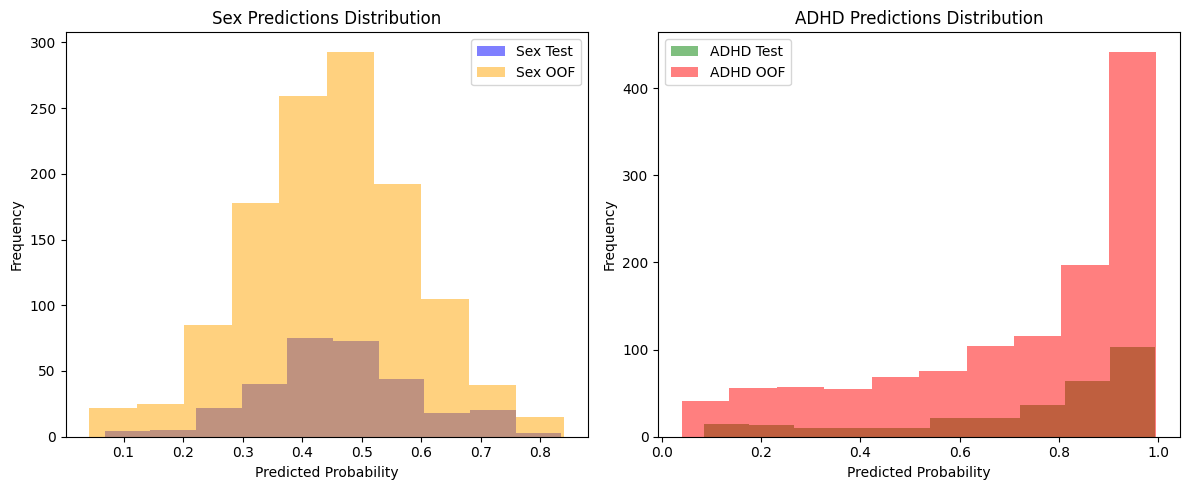

Kolmogorov-Smirnov Test and MannWhitneyU Results:
Sex KS Test vs. OOF: Statistic=0.0632, p-value=0.2718
Sex MWU Test vs. OOF: Statistic=193255.0000, p-value=0.1936
ADHD KS Test vs. OOF: Statistic=0.0594, p-value=0.3423
ADHD MWU Test vs. OOF: Statistic=188859.0000, p-value=0.5116
Share ADHD OOF: 0.8524 - Share ADHD Test: 0.8651
Share Sex_F OOF: 0.9143 - Share Sex_F Test: 0.9474


In [ ]:
# Plotting distributions with improved visuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Sex predictions
ax[0].hist(sex_proba_test, bins=10, alpha=0.5, color='blue', label='Sex Test')
ax[0].hist(sex_oof, bins=10, alpha=0.5, color='orange', label='Sex OOF')
ax[0].set_title('Sex Predictions Distribution')
ax[0].set_xlabel('Predicted Probability')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Plot for ADHD predictions
ax[1].hist(adhd_proba_test, bins=10, alpha=0.5, color='green', label='ADHD Test')
ax[1].hist(adhd_oof, bins=10, alpha=0.5, color='red', label='ADHD OOF')
ax[1].set_title('ADHD Predictions Distribution')
ax[1].set_xlabel('Predicted Probability')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.show()

# Statistical test to compare distributions
sex_test_result = ks_2samp(sex_proba_test, sex_oof)
adhd_test_result = ks_2samp(adhd_proba_test, adhd_oof)
sex_mwu_result = mannwhitneyu(sex_proba_test, sex_oof)
adhd_mwu_result = mannwhitneyu(adhd_proba_test, adhd_oof)

print("Kolmogorov-Smirnov Test and MannWhitneyU Results:")
print(f"Sex KS Test vs. OOF: Statistic={sex_test_result.statistic:.4f}, p-value={sex_test_result.pvalue:.4f}")
print(f"Sex MWU Test vs. OOF: Statistic={sex_mwu_result.statistic:.4f}, p-value={sex_mwu_result.pvalue:.4f}")
print(f"ADHD KS Test vs. OOF: Statistic={adhd_test_result.statistic:.4f}, p-value={adhd_test_result.pvalue:.4f}")
print(f"ADHD MWU Test vs. OOF: Statistic={adhd_mwu_result.statistic:.4f}, p-value={adhd_mwu_result.pvalue:.4f}")

# Submission
submission1 = pd.read_excel("/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")
submission1["ADHD_Outcome"] = np.where(adhd_proba_test > best_adhd_threshold, 1, 0)
submission1["Sex_F"] = np.where(sex_proba_test > best_sex_threshold, 1, 0)
# Compare share of predicted labels at thresholds between OOF and Test
print(f"Share ADHD OOF: {np.mean(np.where(adhd_oof > best_adhd_threshold, 1, 0)):.4f} - Share ADHD Test: {submission1.ADHD_Outcome.mean():.4f}")
print(f"Share Sex_F OOF: {np.mean(np.where(sex_oof > best_sex_threshold, 1, 0)):.4f} - Share Sex_F Test: {submission1.Sex_F.mean():.4f}")

In [ ]:
submission1.to_csv("submission.csv", index=False)

# Try other regression model
## Define models

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

RidgeCV_params = {
    'alpha_per_target': True,
    "alphas": [0.1, 1.0, 10.0], 
    'fit_intercept': True,
    "cv": skf, 
    "scoring": "neg_mean_squared_error", 
}
SVR_params = {
    'C': 1.0,
    'epsilon': 0.1,
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'shrinking': True
}
RF_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'n_jobs': -1,
    'verbose': 0,
}
GB_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'subsample': 0.8,
    'learning_rate': 0.1,
    'loss': 'squared_error',
    'n_jobs': -1,
    'verbose': 0,
}

CatBoost_Params = {
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'learning_rate': 0.1,
    'iterations': 100,
    'l2_leaf_reg': 3,
    'verbose': 0,
    'task_type': 'CPU',
    # 'devices': '0',
}

XGB_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'lambda': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    # 'tree_method': 'gpu_hist',
    # 'predictor': 'gpu_predictor',
    # 'gpu_id': 0,
}

LGBM_params = {
    'n_estimators': 100,
    'num_leaves': 31,
    'max_depth': 10,
    'min_data_in_leaf': 20,
    'learning_rate': 0.1,
    'num_iterations': 100,
    'early_stopping_round': 10,
    'max_bin': 255,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'device': 'gpu',
    'gpu_device_id': 0,
    'verbosity': -1,
}

## Tuning model

In [ ]:
# rskf and return val scores
def train_model(model_name_1, model_name_2, params_1, params_2, train_combined, combinations, test=False):
    model_dict = {
        'SVR': SVR,
        'RidgeCV': RidgeCV,
        'RF': RandomForestRegressor,
        'GBM': GradientBoostingRegressor,
        'CatBoost': CatBoostRegressor,
        'XGB': XGBRegressor,
        'LGBM': LGBMRegressor
    }
    if not test:
        model_1 = model_dict[model_name_1](**params_1)
        model_2 = model_dict[model_name_2](**params_2)

    y_adhd = combinations["ADHD_Outcome"]
    y_sex = combinations["Sex_F"]

    # training
    for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
        X_train, X_val = train_combined.iloc[train_idx], train_combined.iloc[val_idx]
        y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
        y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]

        weights_train = np.where(combinations.iloc[train_idx]=="11", 2, 1)
        weights = np.where(combinations.iloc[val_idx]=="11", 2, 1)

        model_1.fit(X_train[features_sex], y_train_sex, sample_weight=weights_train)
        sex_train = model_1.predict_proba(X_train[features_sex])[:, 1]

        sex_val = model_1.predict_proba(X_val[features_sex])[:, 1]
        sex_oof[val_idx] += sex_val / REPEATS
        sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", thresh=t_sex)
        scores_sex.append((sex_brier, sex_f1))

        X_train["sex_proba"] = sex_train
        X_val["sex_proba"] = sex_val
        for interaction in interactions:
            X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
            X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]
        model_2.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train)
    
        adhd_val = model_2.predict_proba(X_val[features_adhd])[:, 1]
        adhd_oof[val_idx] += adhd_val / REPEATS
        adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "Outcome ADHD", thresh=t_adhd)
        scores_adhd.append((adhd_brier, adhd_f1))

    return sex_oof, adhd_oof, scores_sex, scores_adhd

def optimize_model(weights, thresholds, sex_oof, adhd_oof, scores_sex, scores_adhd):
    sex_scores = []
    for t in tqdm(thresholds, desc="Sex Thresholds"):
        tmp_pred = np.where(sex_oof > t, 1, 0)
        tmp_score = f1_score(y_sex, tmp_pred, sample_weight=weights)
        sex_scores.append(tmp_score)
    best_sex_threshold = thresholds[np.argmax(sex_scores)]
    best_sex_score = max(sex_scores)

    # Compute F1 scores and find the best threshold for adhd_oof
    adhd_scores = []
    for t in tqdm(thresholds, desc="ADHD Thresholds"):
        tmp_pred = np.where(adhd_oof > t, 1, 0)
        tmp_score = f1_score(y_adhd, tmp_pred, sample_weight=weights)
        adhd_scores.append(tmp_score)
    best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
    best_adhd_score = max(adhd_scores)

    return best_sex_threshold, best_adhd_threshold, best_sex_score, best_adhd_score

In [ ]:
import optuna
def objective(trial, models_list=None):
    params = {}

    if 'RidgeCV' in models_list:
        params['RidgeCV'] = {
            'alpha_per_target': trial.suggest_categorical('ridge_alpha_per_target', [True, False]),
            'alphas': trial.suggest_float('ridge_alphas', 1e-2, 10.0, log=True),
            'fit_intercept': trial.suggest_categorical('ridge_fit_intercept', [True, False]),
            'cv': StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED),
            'scoring': 'neg_mean_squared_error',
        }

    if 'SVR' in models_list:
        SVR_Params = {
            'C': trial.suggest_float('svr_C', 1e-2, 10.0, log=True),
            'epsilon': trial.suggest_float('svr_epsilon', 1e-2, 1.0, log=True),
            'degree': trial.suggest_int('svr_degree', 1, 5),
            'gamma': trial.suggest_categorical('svr_gamma', ['scale', 'auto']),
            'kernel': trial.suggest_categorical('svr_kernel', ['linear', 'poly', 'rbf']),
            'shrinking': trial.suggest_categorical('svr_shrinking', [True, False]),         
        }
    if 'RF' in models_list:
        RF_Params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000, 50),
            'max_depth': trial.suggest_int('rf_max_depth', 1, 10),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
            'n_jobs': -1,
            'verbose': 0
        }
    if 'GBM' in models_list:
        GBM_Params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 100, 1000, 50),
            'max_depth': trial.suggest_int('gb_max_depth', 1, 10),
            'min_samples_split': trial.suggest_int('gb_min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('gb_min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('gb_max_features', ['sqrt', 'log2']),
            'subsample': trial.suggest_float('gb_subsample', 0.1, 1.0),
            'learning_rate': trial.suggest_float('gb_lr', 0.01, 0.3, log=True),
            'loss': 'squared_error',
            'n_jobs': -1,
            'verbose': 0
        }
    if 'CatBoost' in models_list:
        CatBoost_Params = {
            # model complexity
            'max_depth': trial.suggest_int('catboost__max_depth', 4, 10),
            # add random noise
            'subsample': trial.suggest_float('catboost_subsample', 0.1, 1.0),
            'colsample_bylevel': trial.suggest_float('catboost_colsample_bylevel', 0.1, 1.0),
            # lr
            'learning_rate': trial.suggest_float('catboost_lr', 1e-3, 0.3, log=True),
            'iterations': trial.suggest_int('catboost_iter', 100, 400, 10),
            # regularization
            'l2_leaf_reg': trial.suggest_float('catboost_l2_leaf_reg', 0.01, 10.0, log=True),
            # devices
            'verbose': 0,
            'task_type': 'GPU',  
            'devices': '0'      
        }
    if 'XGB' in models_list:
        XGB_Params = {
            # model complexity
            'n_estimators': trial.suggest_int('xgb_n_estimators', 500, 1500, 100),
            'max_depth': trial.suggest_int('xgb_max_depth', 1, 10),
            'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 100),
            'gamma': trial.suggest_float('xgb_gamma', 1e-2, 1.0),
            # add random noise
            'subsample': trial.suggest_float('xgb_subsample', 0.1, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.05, 1.0),
            # lr
            'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.1, log=True),
            # regularization
            'lambda': trial.suggest_float('xgb_lambda', 1e-2, 10.0, log=True),
            # devices & reg task
            'eval_metric': 'rmse',
            'objective': 'reg:squarederror',
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'gpu_id': 0
        }
    if 'LGBM' in models_list:
        LGBM_Params = {
            # model complexity
            'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 1000, 50),
            #  grow shallower trees
            'num_leaves': trial.suggest_int('lgbm_num_leaves', 16, 256), 
            'max_depth': trial.suggest_int('lgbm_max_depth', 3, 12), 
            'min_data_in_leaf': trial.suggest_int('lgbm_min_data_in_leaf', 5, 50),   
            # grow less trees & early stopping
            'learning_rate': trial.suggest_float('lgbm_lr', 0.01, 0.1),
            'num_iterations': trial.suggest_int('lgbm_num_iter', 100, 1000, 50),
            'early_stopping_rounds': trial.suggest_int('lgbm_early_stopping_rounds', 10, 100),
            # enable feature pre-filtering: feat fract, max_bin (and max_cat_threshold when multiple classes)
            'max_bins': trial.suggest_int('lgbm_max_bins', 10, 255),
            'feature_fraction': trial.suggest_float('lgbm_feature_fraction', 0.7, 1.0), 
            # use less data 
            'bagging_fraction': trial.suggest_float('lgbm_bagging_fraction', 0.7, 1.0),  
            'bagging_freq': trial.suggest_int('lgbm_bagging_freq', 1, 5),
            # regularization
            'lambda_l1': trial.suggest_float('lgbm_lambda_l1', 0.0, 10.0), 
            'lambda_l2': trial.suggest_float('lgbm_lambda_l2', 0.0, 10.0),
            # devices
            'device_type': 'gpu',
            'gpu_device_id': 0,
            'verbosity': -1  
        }
    sex_oof, adhd_oof, scores_sex, scores_adhd = train_model(models_list[0], models_list[1], params[models_list[0]], params[models_list[1]], train_combined, combinations)
    best_sex_threshold, best_adhd_threshold, best_sex_score, best_adhd_score = optimize_model(weights, thresholds, sex_oof, adhd_oof)
    return best_sex_score * 1.5 + best_adhd_score

## Define model_list and other params

In [ ]:
model_list = ['RidgeCV', 'XGB']
TUNING = False
n_trials = 2

In [ ]:
if TUNING:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_types=model_list), n_trials=n_trials)
    best_params = study.best_params
    RidgeCV_Params = {
        'alpha_per_target': best_params['ridge_alpha_per_target'],
        'alphas': best_params['ridge_alphas'],
        'store_cv_values': best_params['ridge_store_cv_values'],
        'fit_intercept': best_params['ridge_fit_intercept'],
        'cv': StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED),
    }

    SVR_Params = {
        'C': best_params['svr_C'],
        'epsilon': best_params['svr_epsilon'],
        'degree': best_params['svr_degree'],
        'gamma': best_params['svr_gamma'],
        'kernel': best_params['svr_kernel'],
        'shrinking': best_params['svr_shrinking'],         
    }

    RF_Params = {
        'n_estimators': best_params['rf_n_estimators'],
        'max_depth': best_params['rf_max_depth'],
        'min_samples_split': best_params['rf_min_samples_split'],
        'min_samples_leaf': best_params['rf_min_samples_leaf'],
        'max_features': best_params['rf_max_features'],
        'bootstrap': best_params['rf_bootstrap'],
        'n_jobs': -1,
        'verbose': 0
    }

    GB_Params = {
        'n_estimators': best_params['gb_n_estimators'],
        'max_depth': best_params['gb_max_depth'],
        'min_samples_split': best_params['gb_min_samples_split'],
        'min_samples_leaf': best_params['gb_min_samples_leaf'],
        'max_features': best_params['gb_max_features'],
        'subsample': best_params['gb_subsample'],
        'learning_rate': best_params['gb_lr'],
        'loss': 'squared_error',
        'n_jobs': -1,
        'verbose': 0
    }

    CatBoost_Params = {
        'max_depth': best_params['catboost__max_depth'],
        'subsample': best_params['catboost_subsample'],
        'colsample_bylevel': best_params['catboost_colsample_bylevel'],
        'learning_rate': best_params['catboost_lr'],
        'iterations': best_params['catboost_iter'],
        'l2_leaf_reg': best_params['catboost_l2_leaf_reg'],
        'verbose': 0,
        'task_type': 'CPU',  
        # 'devices': '0'      
    }

    XGB_Params = {
        'n_estimators': best_params['xgb_n_estimators'],
        'max_depth': best_params['xgb_max_depth'],
        'min_child_weight': best_params['xgb_min_child_weight'],
        'gamma': best_params['xgb_gamma'],
        'subsample': best_params['xgb_subsample'],
        'colsample_bytree': best_params['xgb_colsample_bytree'],
        'learning_rate': best_params['xgb_lr'],
        'lambda': best_params['xgb_lambda'],
        'eval_metric': 'rmse',
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'gpu_id': 0
    }

    LGBM_Params = {
        'n_estimators': best_params['lgbm_n_estimators'],
        'num_leaves': best_params['lgbm_num_leaves'],
        'max_depth': best_params['lgbm_max_depth'],
        'min_data_in_leaf': best_params['lgbm_min_data_in_leaf'],   
        'learning_rate': best_params['lgbm_lr'],
        'num_iterations': best_params['lgbm_num_iter'],
        'early_stopping_rounds': best_params['lgbm_early_stopping_rounds'],
        'max_bins': best_params['lgbm_max_bins'],
        'feature_fraction': best_params['lgbm_feature_fraction'], 
        'bagging_fraction': best_params['lgbm_bagging_fraction'],  
        'bagging_freq': best_params['lgbm_bagging_freq'],
        'lambda_l1': best_params['lgbm_lambda_l1'], 
        'lambda_l2': best_params['lgbm_lambda_l2'],
        'device_type': 'gpu',
        'gpu_device_id': 0,
        'verbosity': -1  
    }

## Train again with best params

In [ ]:
model1 = RidgeCV(**RidgeCV_params)
model1 = SVR(**SVR_params)
model1 = RandomForestRegressor(**RF_params)
model1 = GradientBoostingRegressor(**GB_params)
model1 = CatBoostRegressor(**CatBoost_Params)
model1 = XGBRegressor(**XGB_params)
model1 = LGBMRegressor(**LGBM_params)

model2 = RidgeCV(**RidgeCV_params)
model2 = SVR(**SVR_params)
model2 = RandomForestRegressor(**RF_params)
model2 = GradientBoostingRegressor(**GB_params)
model2 = CatBoostRegressor(**CatBoost_Params)

sex_oof, adhd_oof, scores_sex, scores_adhd = train_model(model1, model2, train_combined, combinations, test=True)
best_sex_threshold, best_adhd_threshold, best_sex_score, best_adhd_score = optimize_model(weights, thresholds, sex_oof, adhd_oof)